#Experiment 1: Baseline Logistic Regression on LendingClub

##Step 0: Setup Environment

In [ ]:
# Install required libraries
!pip install aif360 shap scikit-learn pandas matplotlib seaborn --quiet

In [ ]:

# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import shap
import matplotlib.pyplot as plt

from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric


##Step 1: Load and Preprocess LendingClub Dataset

In [ ]:

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')  # path

# Select relevant columns
selected_cols = ['loan_status', 'annual_inc', 'term', 'grade', 'home_ownership', 'purpose', 'zip_code']
df = df[selected_cols].dropna()

# Convert target to binary
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

# Encode categorical features
for col in ['term', 'grade', 'home_ownership', 'purpose', 'zip_code']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Normalize income
df['annual_inc'] = StandardScaler().fit_transform(df[['annual_inc']])


/tmp/ipython-input-1265486919.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')  # path


In [ ]:
# from google.colab import drive
#drive.mount('/content/drive')

##Step 2: Create AIF360 Dataset

In [ ]:

# Define privileged and unprivileged groups (e.g., zip_code as proxy)
privileged_groups = [{'zip_code': 1}]
unprivileged_groups = [{'zip_code': 0}]

# Create AIF360 dataset
aif_data = StandardDataset(df,
                           label_name='loan_status',
                           favorable_classes=[1],
                           protected_attribute_names=['zip_code'],
                           privileged_classes=[[1]])


## Step 3: Train Baseline Logistic Regression

In [ ]:

# Extract features and labels
X = aif_data.features
y = aif_data.labels.ravel()

# Train model
clf = LogisticRegression(max_iter=1000)
clf.fit(X, y)

# Predict
y_pred = clf.predict(X)
y_prob = clf.predict_proba(X)[:, 1]


## Step 4: Evaluate Performance and Fairness

In [ ]:

# Performance metrics
print("Accuracy:", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))
print("F1 Score:", f1_score(y, y_pred))
print("AUC-ROC:", roc_auc_score(y, y_prob))
print(classification_report(y, y_pred))

# Fairness metrics
pred_dataset = aif_data.copy()
pred_dataset.labels = y_pred.reshape(-1, 1)

metric = ClassificationMetric(aif_data, pred_dataset,
                              unprivileged_groups=unprivileged_groups,
                              privileged_groups=privileged_groups)

print("Statistical Parity Difference:", metric.statistical_parity_difference())
print("Disparate Impact:", metric.disparate_impact())
print("Equal Opportunity Difference:", metric.equal_opportunity_difference())
print("Average Odds Difference:", metric.average_odds_difference())
print("Bias Amplification:", metric.between_group_generalized_entropy_index())
print("Theil Index:", metric.theil_index())


Accuracy: 0.7756
Precision: 0.8277299973937973
Recall: 0.8732471817431949
F1 Score: 0.8498795825528499
AUC-ROC: 0.7980375536262079
              precision    recall  f1-score   support

         0.0       0.60      0.52      0.56      1363
         1.0       0.83      0.87      0.85      3637

    accuracy                           0.78      5000
   macro avg       0.72      0.69      0.70      5000
weighted avg       0.77      0.78      0.77      5000

Statistical Parity Difference: -0.07692307692307687
Disparate Impact: 0.9230769230769231
Equal Opportunity Difference: -0.08333333333333337
Average Odds Difference: -0.041666666666666685
Bias Amplification: 170.3984375
Theil Index: 0.1369986277506124


## Step 5: SHAP Explainability (Baseline)

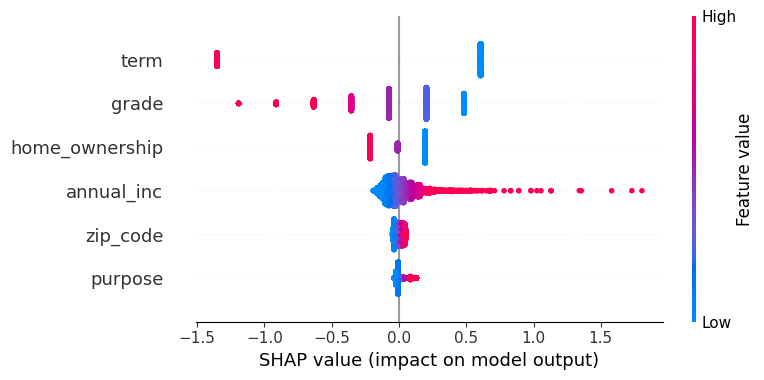

In [ ]:

# SHAP analysis
explainer = shap.LinearExplainer(clf, X)
shap_values = explainer.shap_values(X)

# Plot
shap.summary_plot(shap_values, pd.DataFrame(X, columns=aif_data.feature_names))


## Optional: Save Results

In [ ]:

results = {
    'Accuracy': accuracy_score(y, y_pred),
    'Precision': precision_score(y, y_pred),
    'Recall': recall_score(y, y_pred),
    'F1': f1_score(y, y_pred),
    'AUC': roc_auc_score(y, y_prob),
    'SPD': metric.statistical_parity_difference(),
    'DI': metric.disparate_impact(),
    'EOD': metric.equal_opportunity_difference(),
    'AOD': metric.average_odds_difference(),
    'BiasAmp': metric.between_group_generalized_entropy_index(),
    'Theil': metric.theil_index()
}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/Research_Thesis_Implementation/baseline_results.csv', index=False)
